## Example 3: Where do things break?
**Lecture:** Bayesian Statistical Inference

**Date:** 22/11/23

**Course:** Statistical Estimation for Physics

*Summary:* In this final example, we want to see if we can break the straightforward grid approach we have been trying so far.

### Imports

In [1]:
#!pip install numpy matplotlib jax jaxlib
# Uncomment the above line to install the packages
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import corner
import numpy as np

plt.style.use("lecture.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Definitions of the prior, likelihood, and posterior classes

Now we need to define a prior across the 2d-model space $(f_0, A_s)$. Let's assume we are looking for signals that could fall within the detection window, so in line with the frequency grid above, we take $p(f_0) \sim U(-1, 21)$ (accounting for the fact that we might be able to see a portion of the signal even if $f_0$ is outside the nominal range). Then, there is a physical minimum amplitude at $A_s = 0$, so let's take $p(A_s) \sim U(0, 20)$ (note that this upper limit is actually arbitrary, a good example of something we should check in general).

**Programming Note:** We have used the `functools` method `partial` to `jit`-compiile class methods

**Programming Note:** As mentioned above and hinted at in Example 1, we have coded up the log probabilities rather than the density directly. This is much, much better behaved numerically.

In [2]:
class Prior:
    def __init__(self, Ndim):
        self.name = "prior"
        self.min = -5.
        self.max = 5.
        self.Ndim = Ndim

    @partial(jax.jit, static_argnums=(0,))
    def log_density(self, theta):
        return jnp.log(
            (1.0 / (self.max - self.min)) ** self.Ndim
            * jnp.prod(jnp.heaviside(theta - self.min, 1.0))
            * jnp.prod(jnp.heaviside(self.max - theta, 1.0))
        )

    def sample(self, size):
        return jax.random.uniform(
            jax.random.PRNGKey(time.time_ns()),
            shape=(size, self.Ndim),
            minval=self.min,
            maxval=self.max,
        )


class Likelihood:
    def __init__(
        self,
        Ndim
    ):
        self.name = "likelihood"
        self.Ndim = Ndim

    @partial(jax.jit, static_argnums=(0,))
    def log_density(self, x, theta):
        return -0.5 * jnp.sum((x - theta) ** 2)

    def sample(self, theta, key=None):
        if key is None: return jax.random.normal(
            jax.random.PRNGKey(time.time_ns()),
            shape=(self.Ndim,),
        ) + theta
        else: return jax.random.normal(
            key,
            shape=(self.Ndim,),
        ) + theta


class Posterior:
    def __init__(self, prior, likelihood):
        self.name = "posterior"
        self.prior = prior
        self.likelihood = likelihood

    @partial(jax.jit, static_argnums=(0,))
    def log_density(self, theta, x):
        return self.prior.log_density(theta) + self.likelihood.log_density(x, theta)

### Prior sampling check
Let's just do a quick check of the prior sampling to make sure we reproduce the uniform distributions

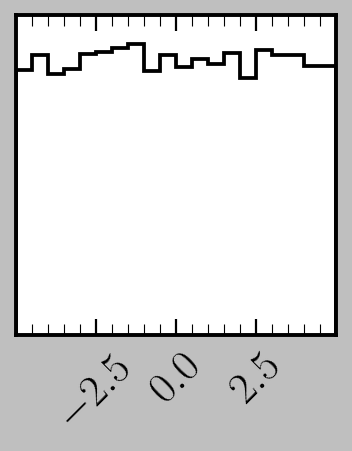

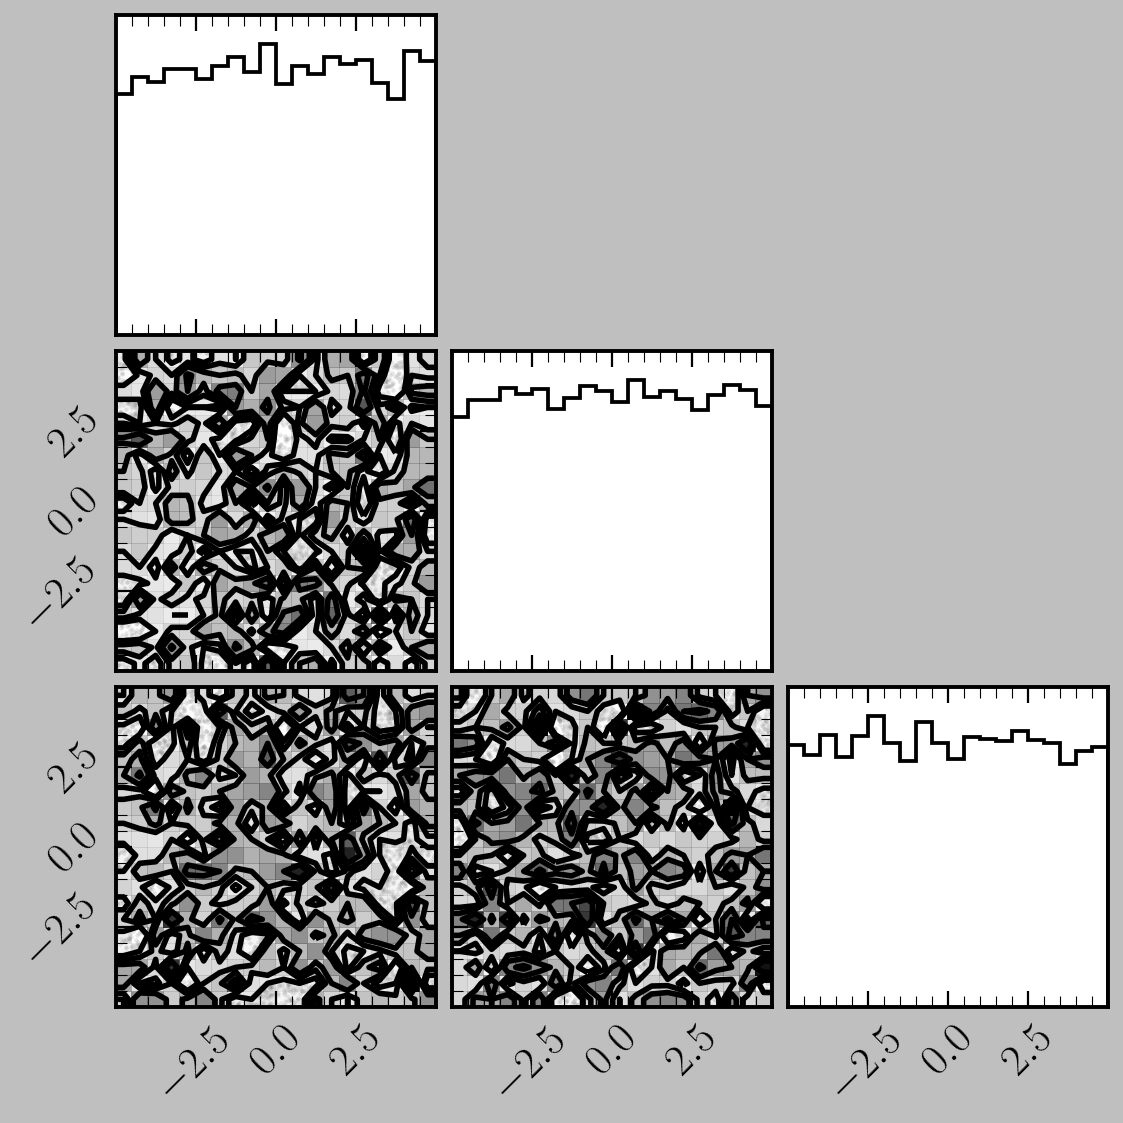

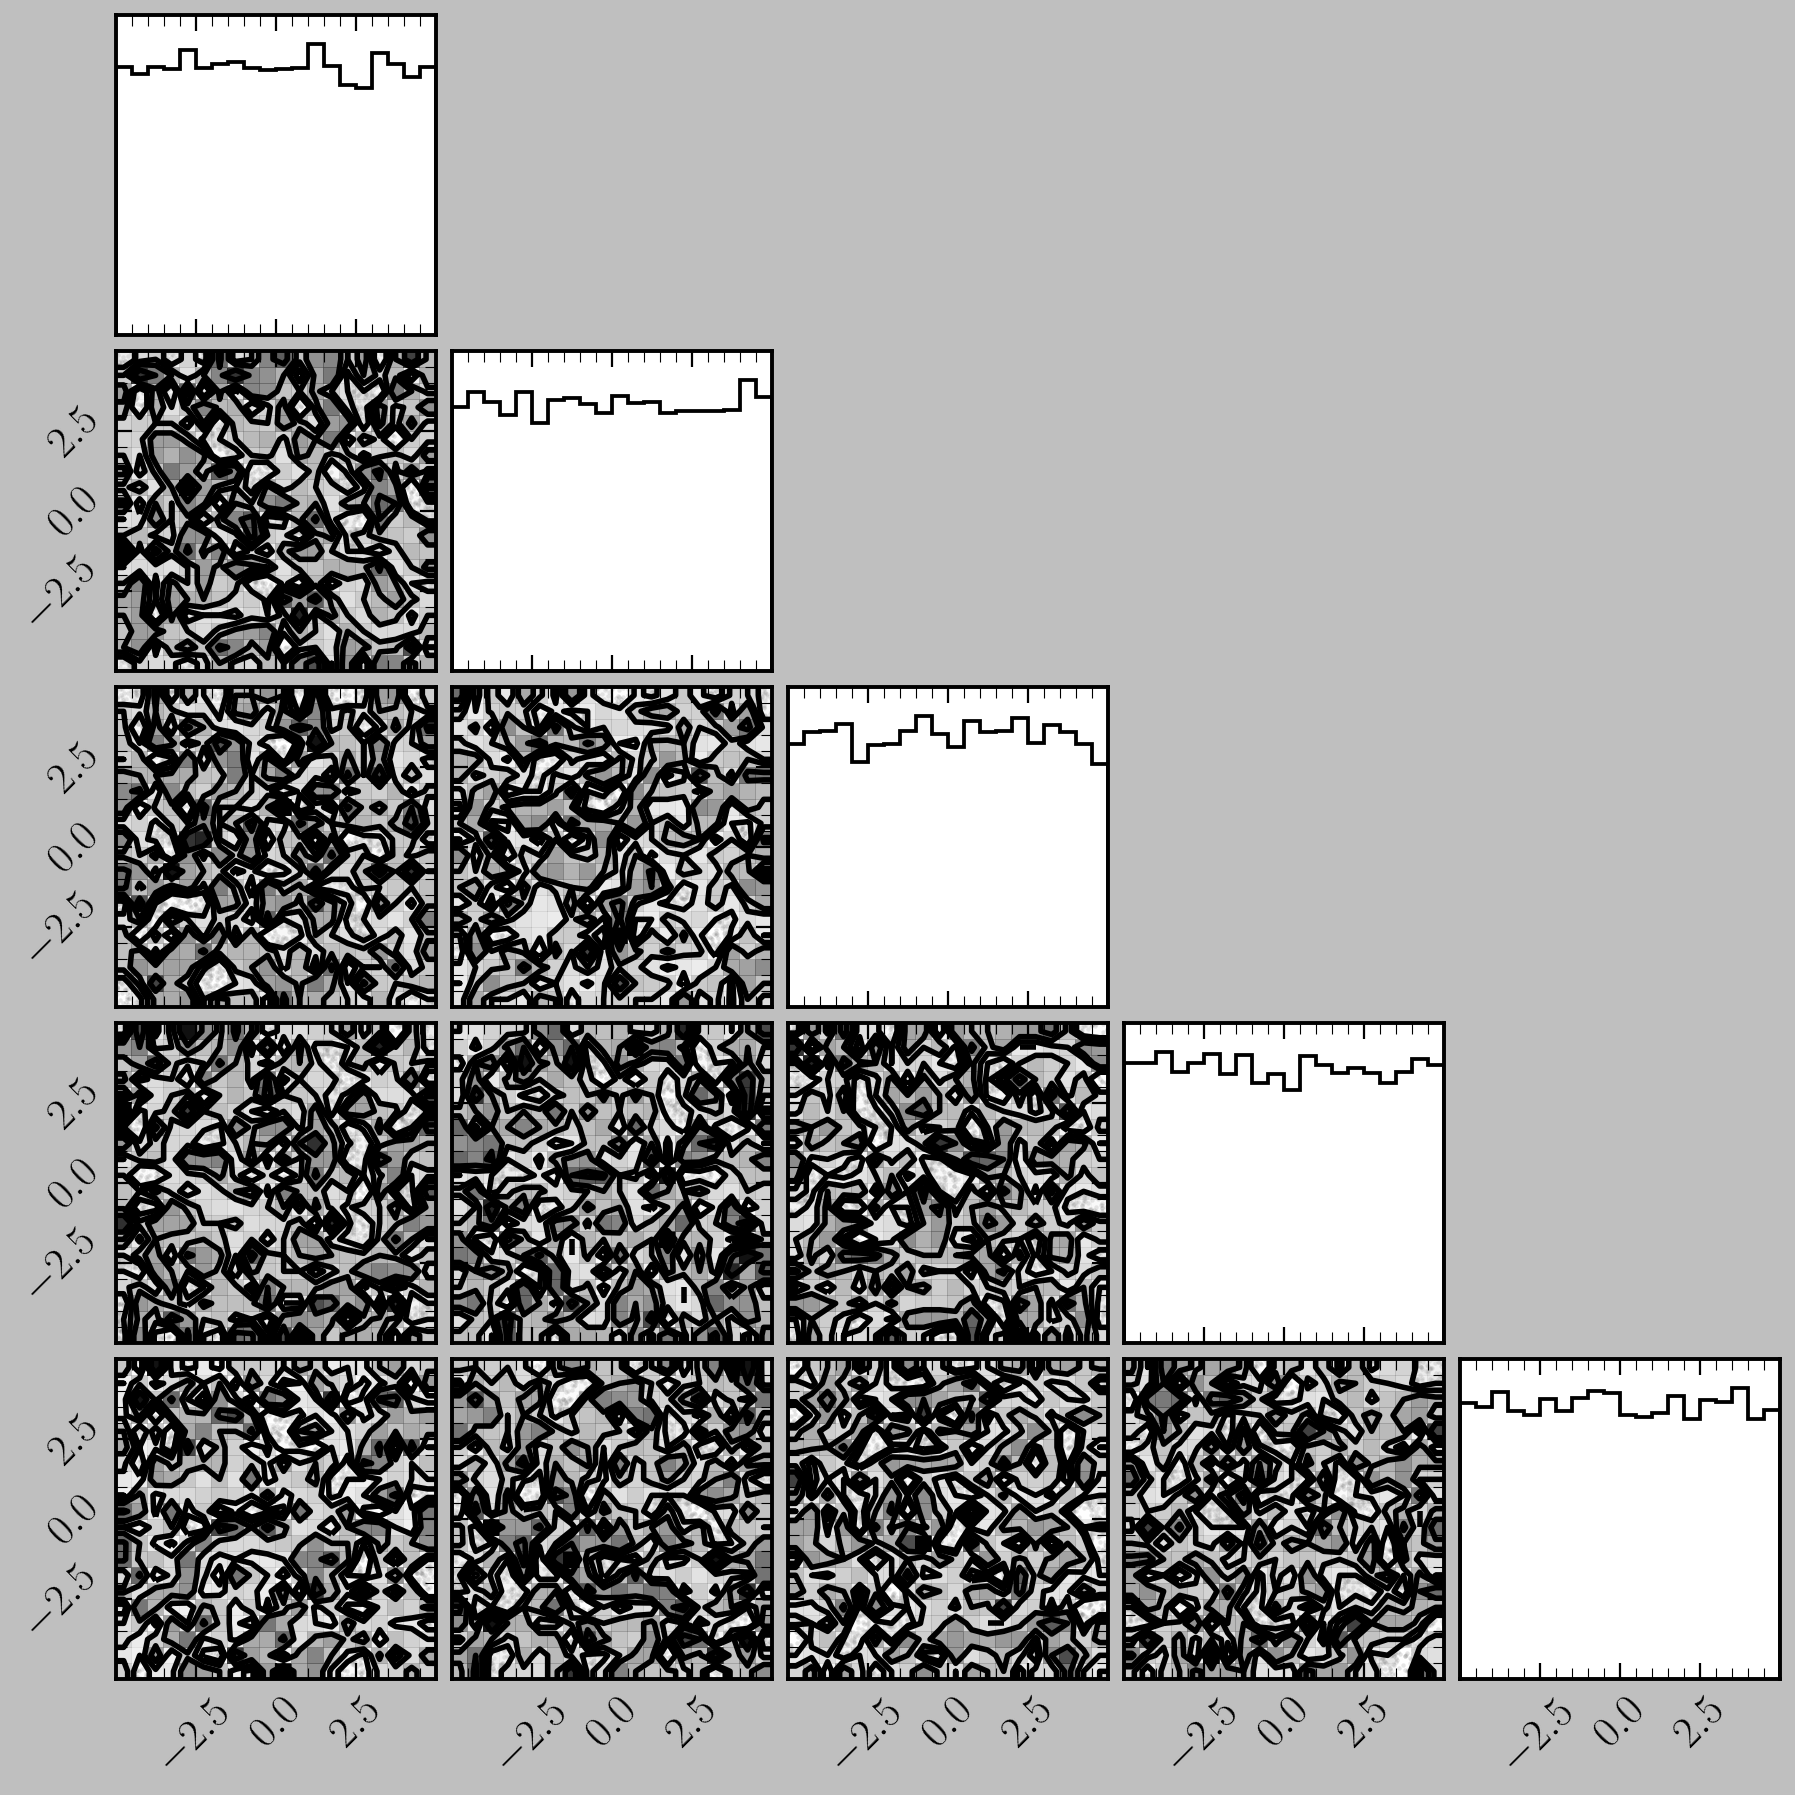

In [3]:
prior = Prior(Ndim=1)
theta_sample = prior.sample(10000)
corner.corner(np.array(theta_sample))
plt.show()

prior = Prior(Ndim=3)
theta_sample = prior.sample(10000)
corner.corner(np.array(theta_sample))
plt.show()

prior = Prior(Ndim=5)
theta_sample = prior.sample(10000)
corner.corner(np.array(theta_sample))
plt.show()

### Likelihood evaluation

Now let's focus on the likelihood itself. We will do the same as we did in Example 1 and evaluate the likelihood on a grid for fixed data $x$.

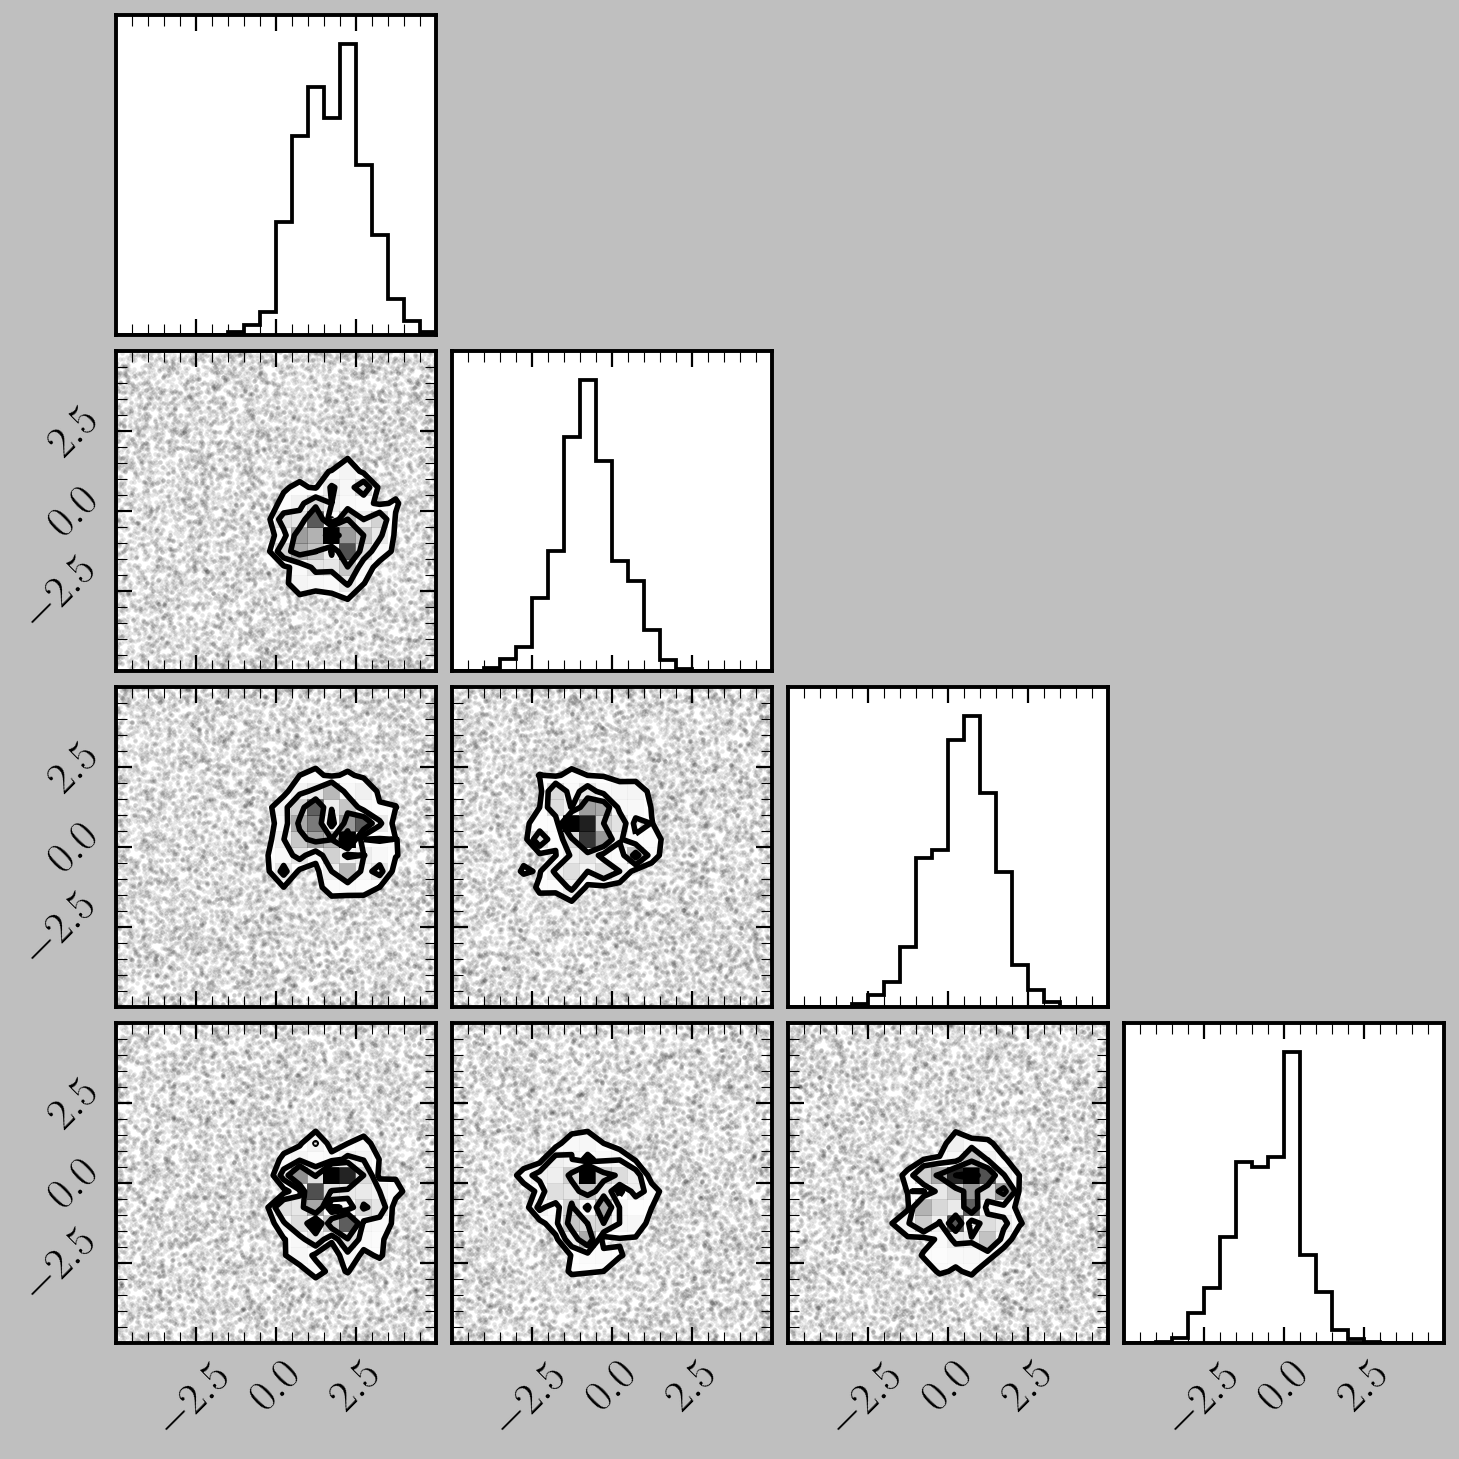

In [4]:
Ndim = 4
likelihood = Likelihood(Ndim=Ndim)
prior = Prior(Ndim=Ndim)
theta_true = jnp.zeros(Ndim)
N_samples = 10000
x_data = likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = prior.sample(N_samples)
log_like_arr = jax.vmap(likelihood.log_density, in_axes=(None, 0))(x_data, theta_sample)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_like_arr - jnp.max(log_like_arr))))
plt.show()

### Posterior Evaluation

Finally we can actually perform inference. As you can see in the `Posterior` class above, for a fixed observation $x_0$, we can easily compute the (unnormalised) log-posterior density by taking the sum of the prior and the likelihood as a function of $\theta$. Then, we can use the same tricks as above (i.e. the `jax.vmap` call) to efficiently compute the posterior on a grid of $\theta$ values.

### **Exercise:** Run this block multiple times (i.e. resample the data by changing the key), how does the posterior shift around? Can you relate that to the behaviour of the likelihood above? What happens if you vary the injection value of $\theta$ (again, you will have to change the plotting limits)?

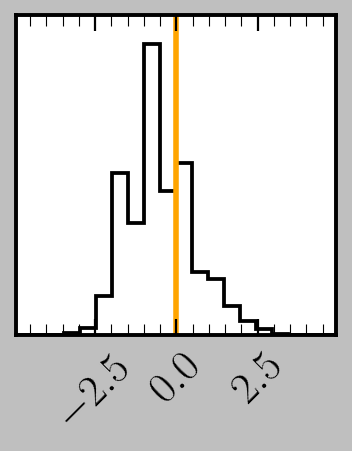

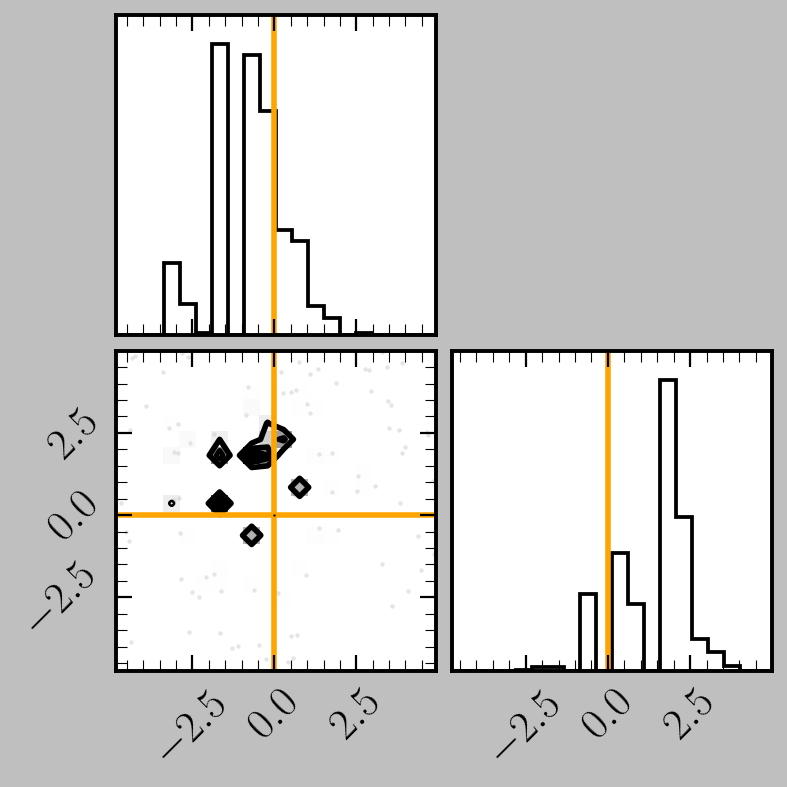

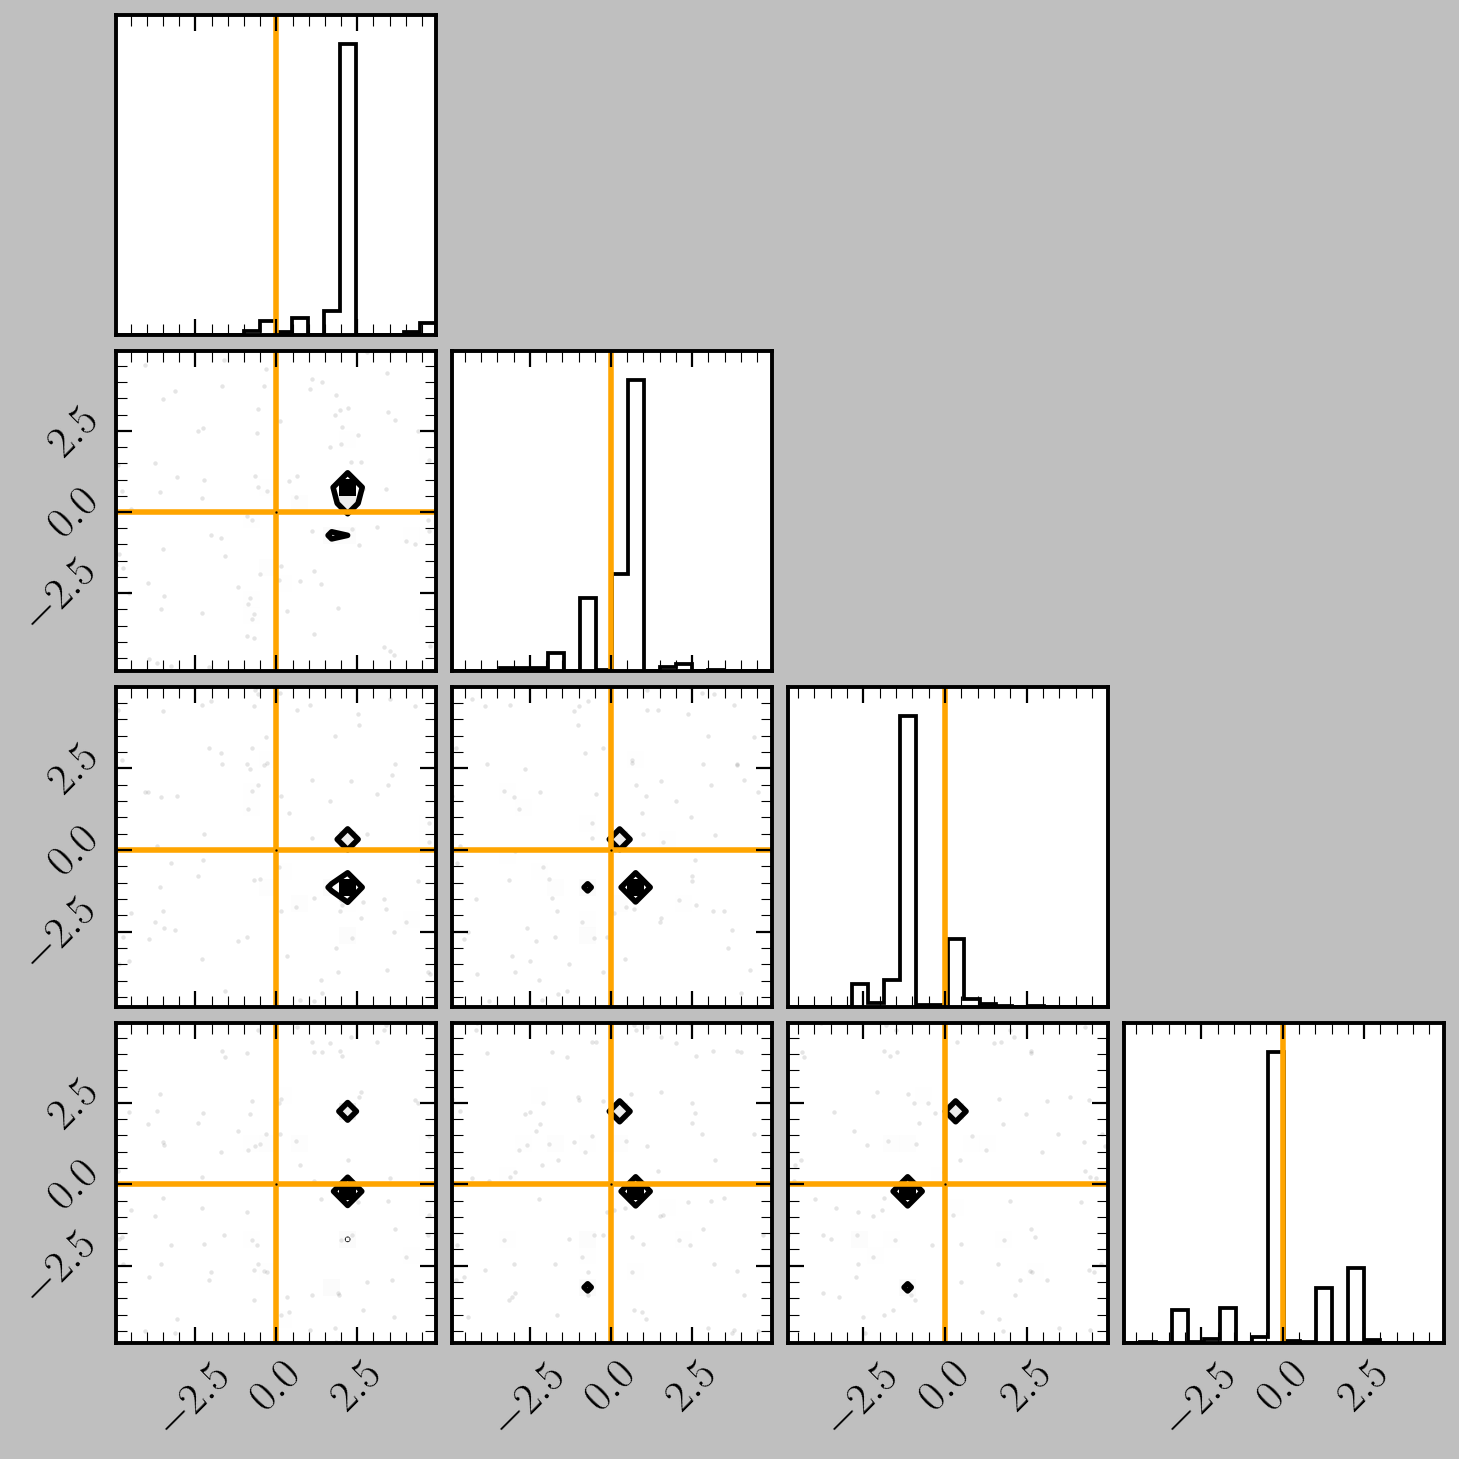

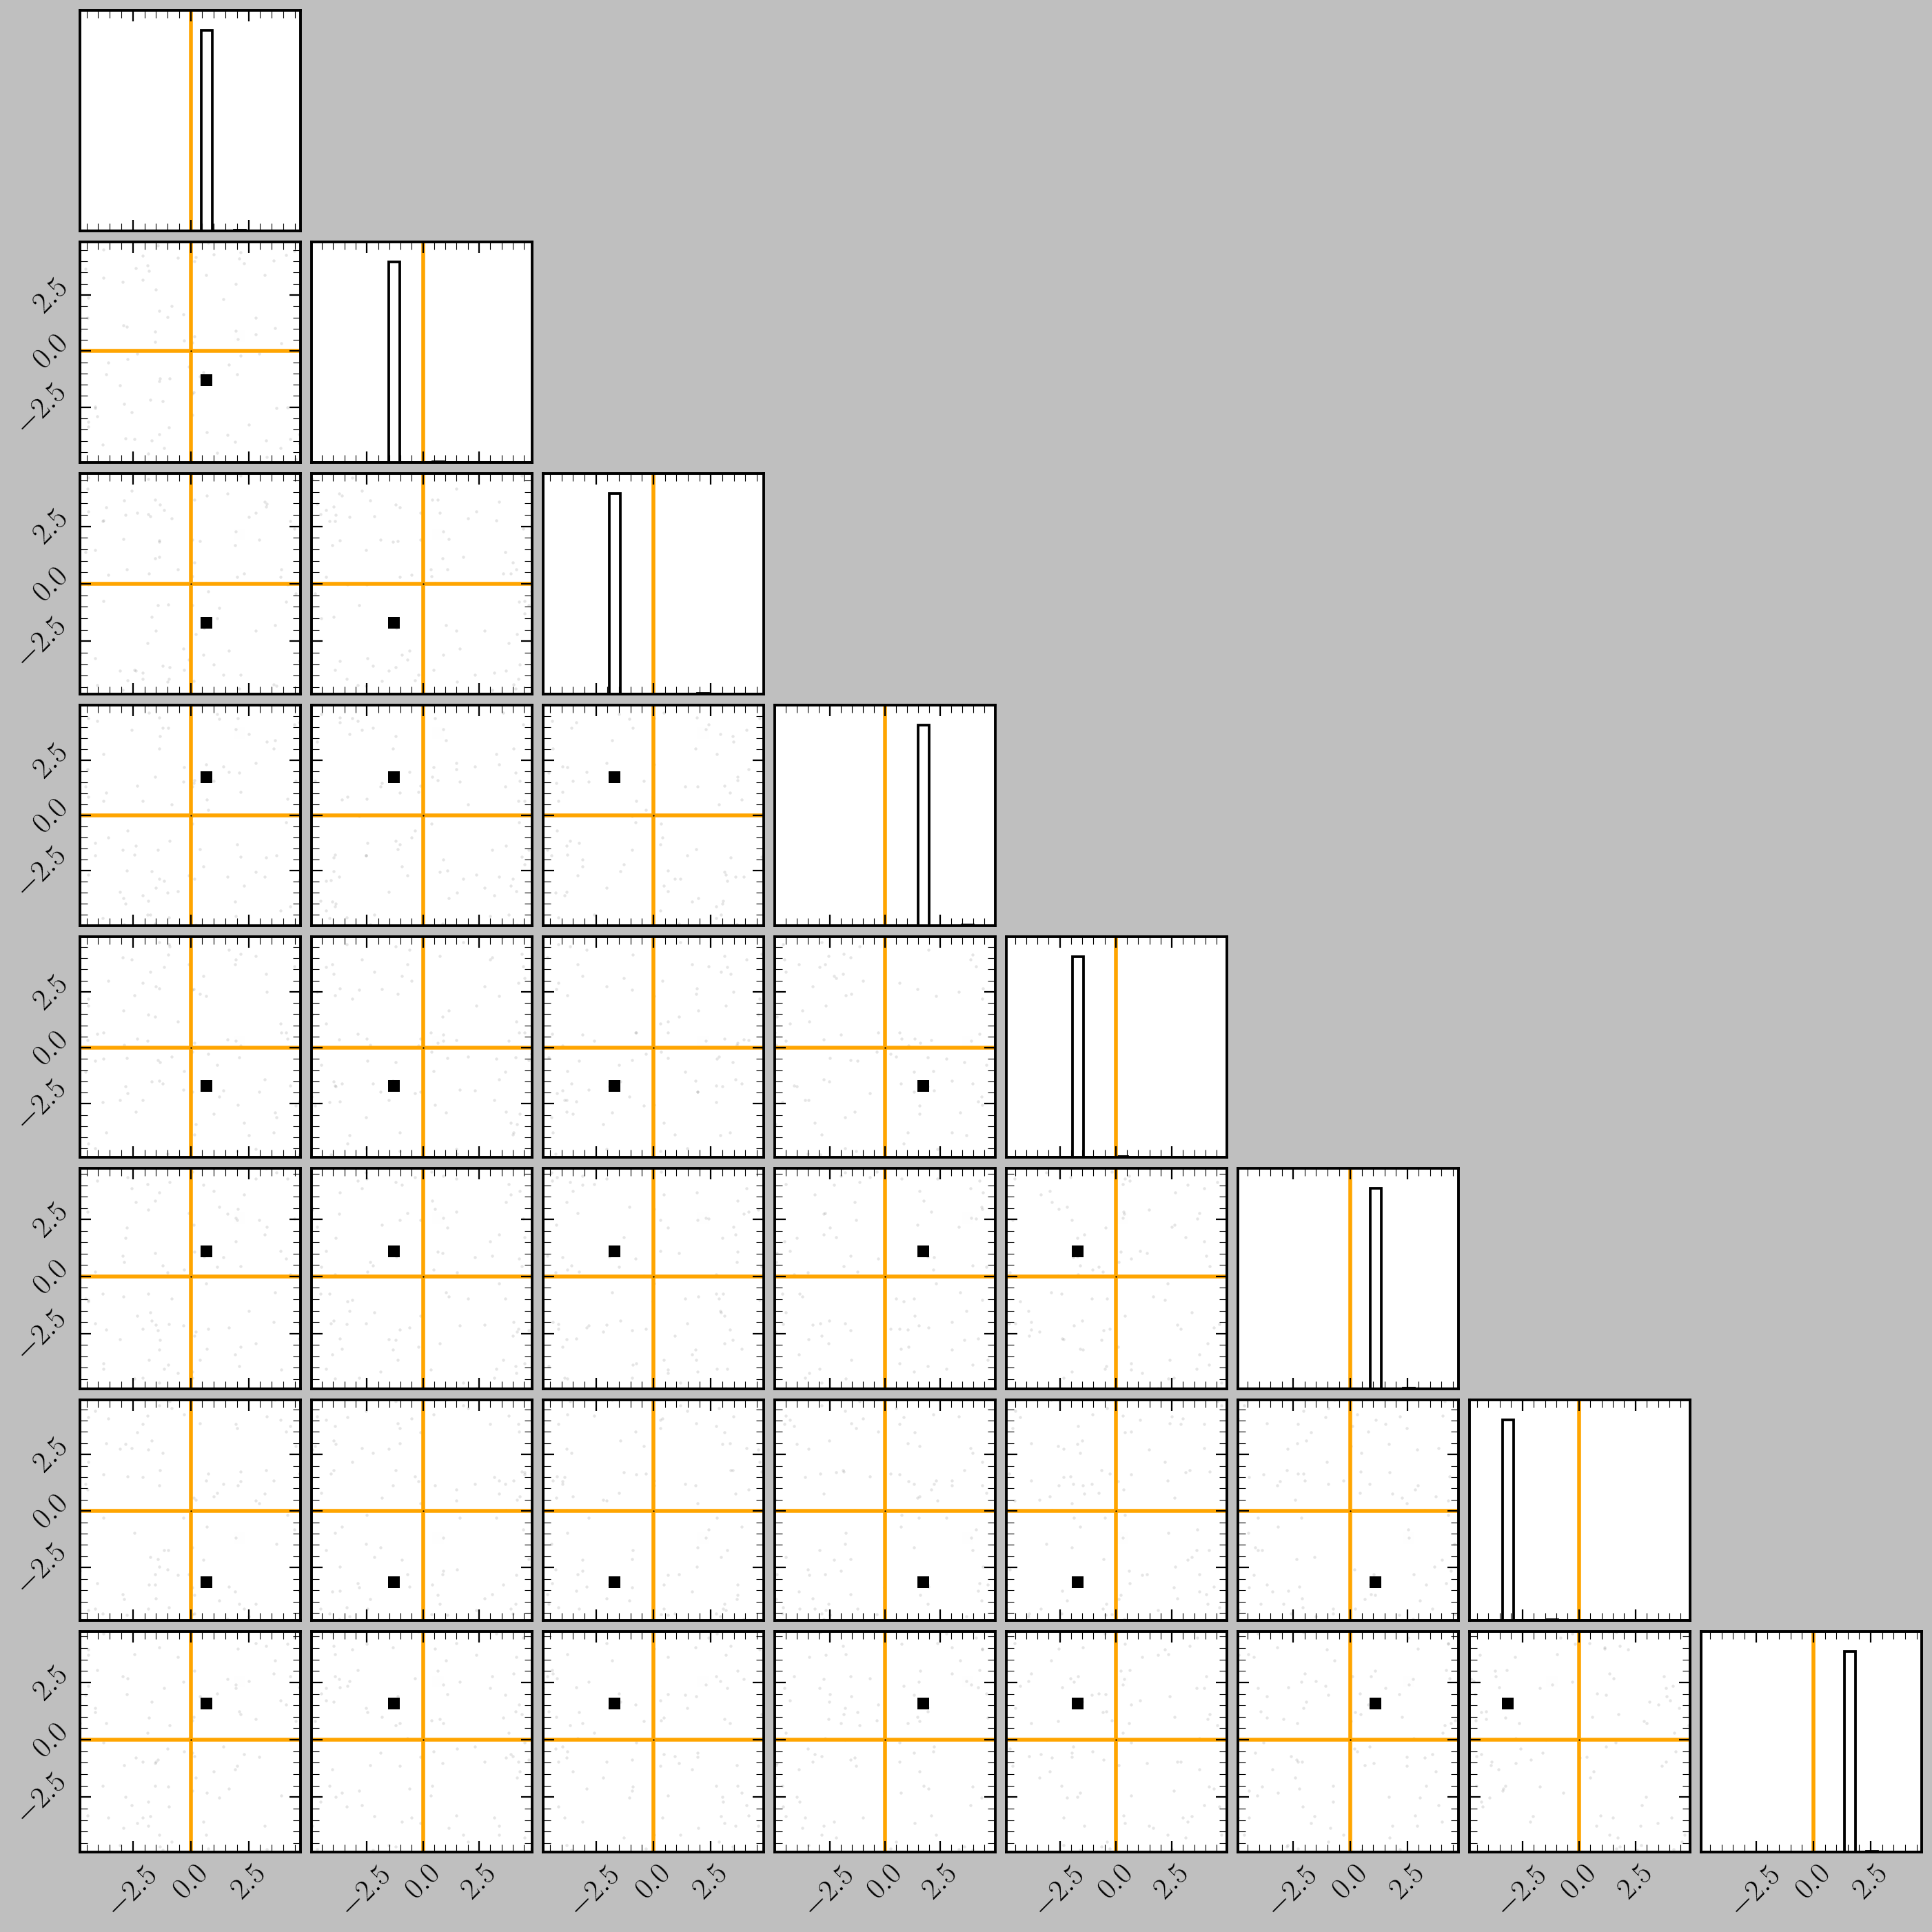

In [5]:
Ndim = 1
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)
N_samples = 100
x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.show()

Ndim = 2
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)
N_samples = 100
x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.show()

Ndim = 4
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)
N_samples = 100
x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.show()

Ndim = 8
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)
N_samples = 100
x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.plot(np.linspace(-5, 5, 100), color="red", label="Gaussian")
plt.show()

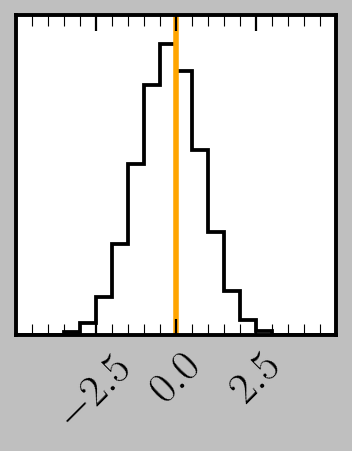

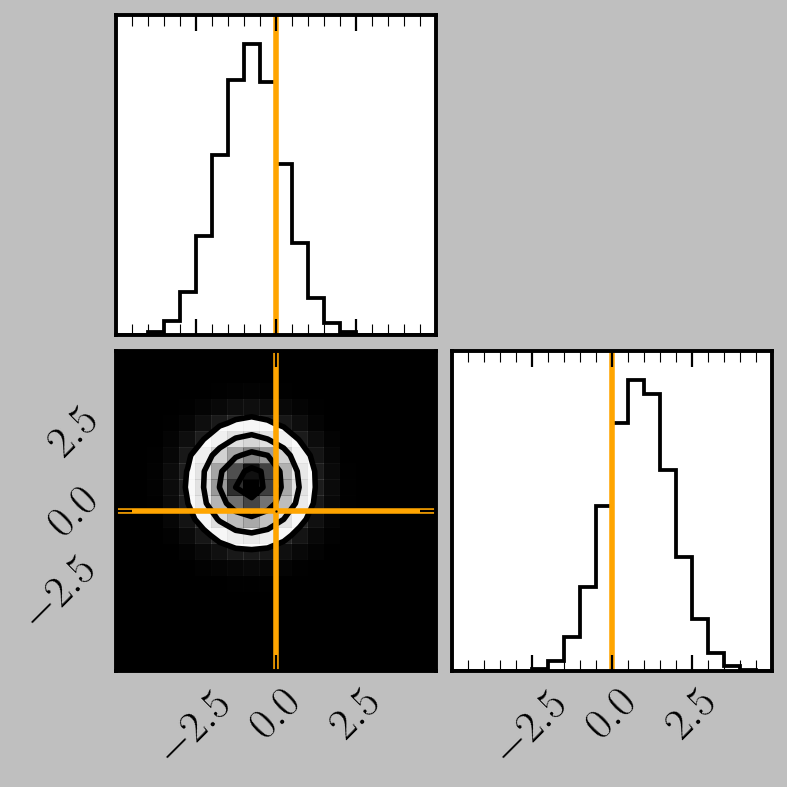

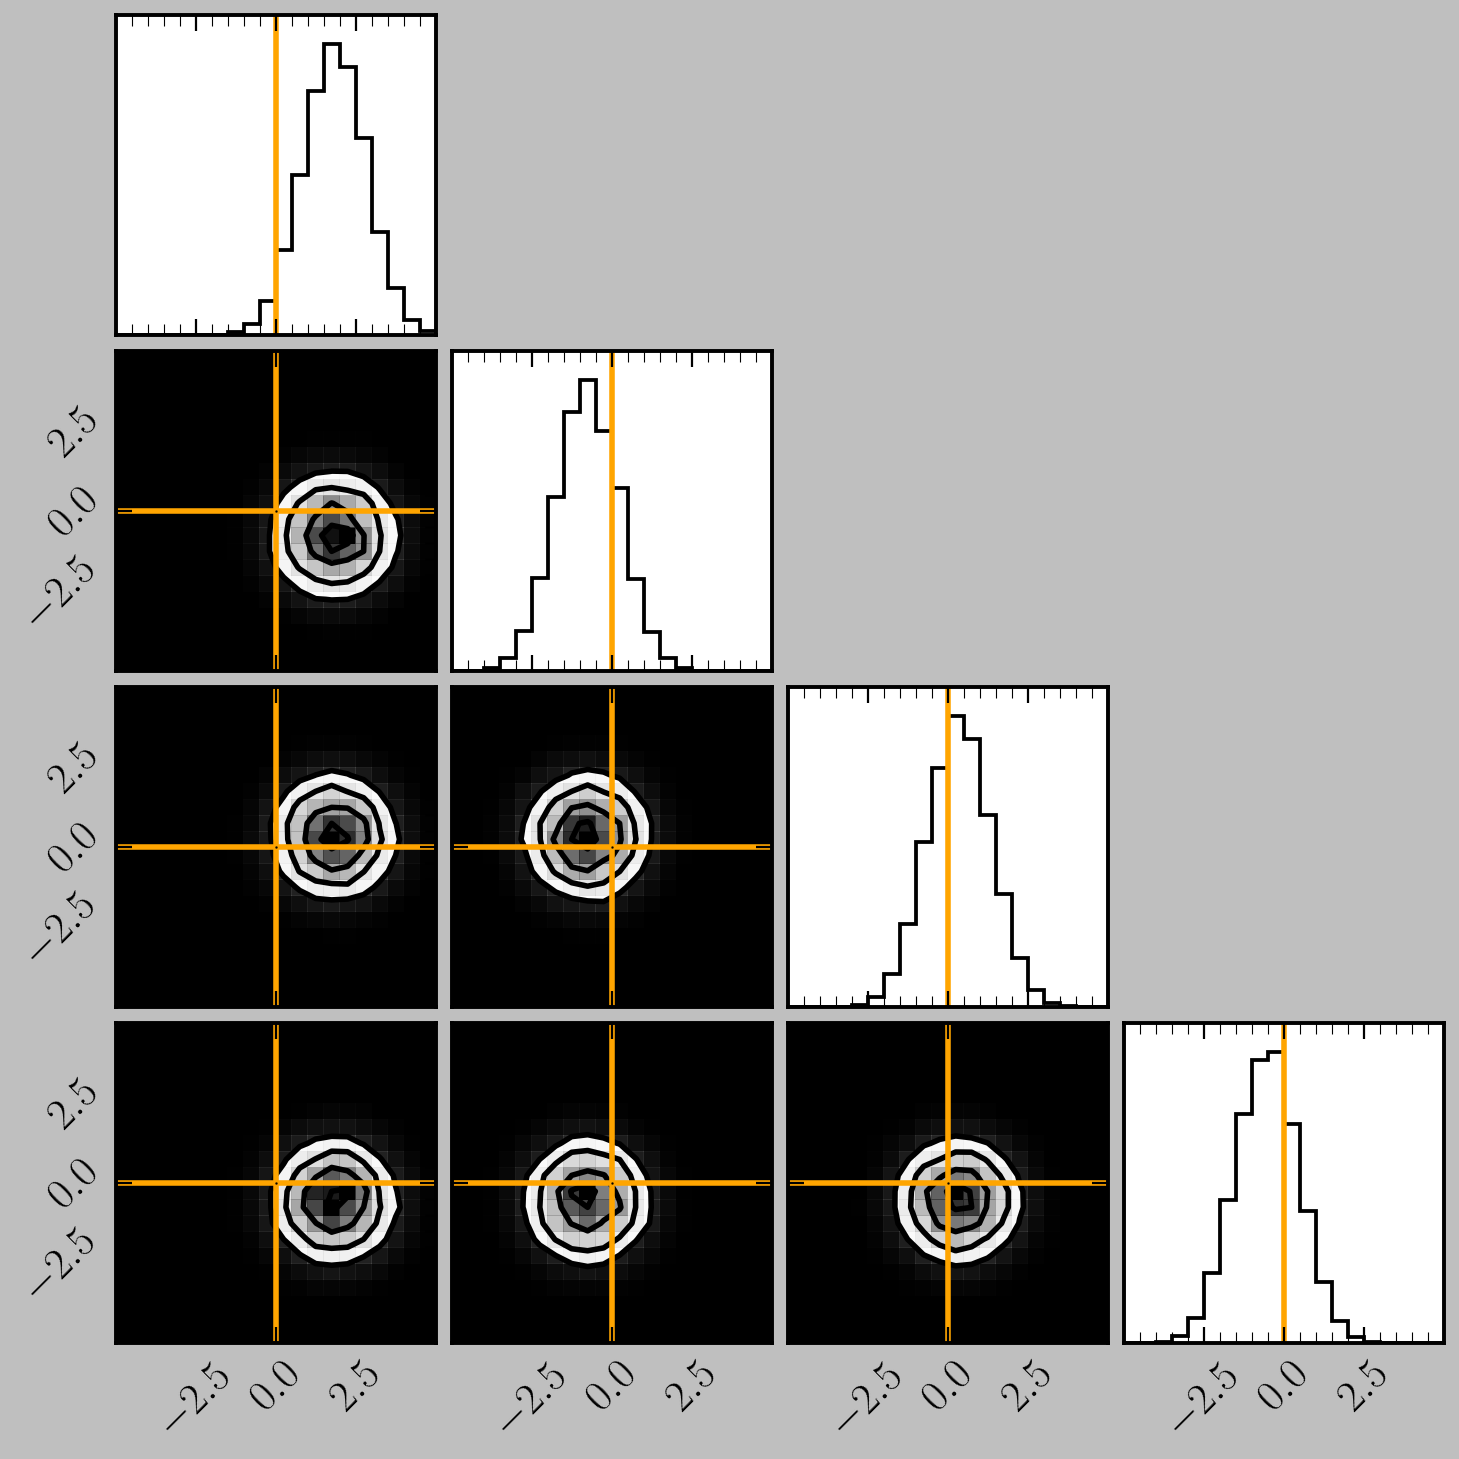

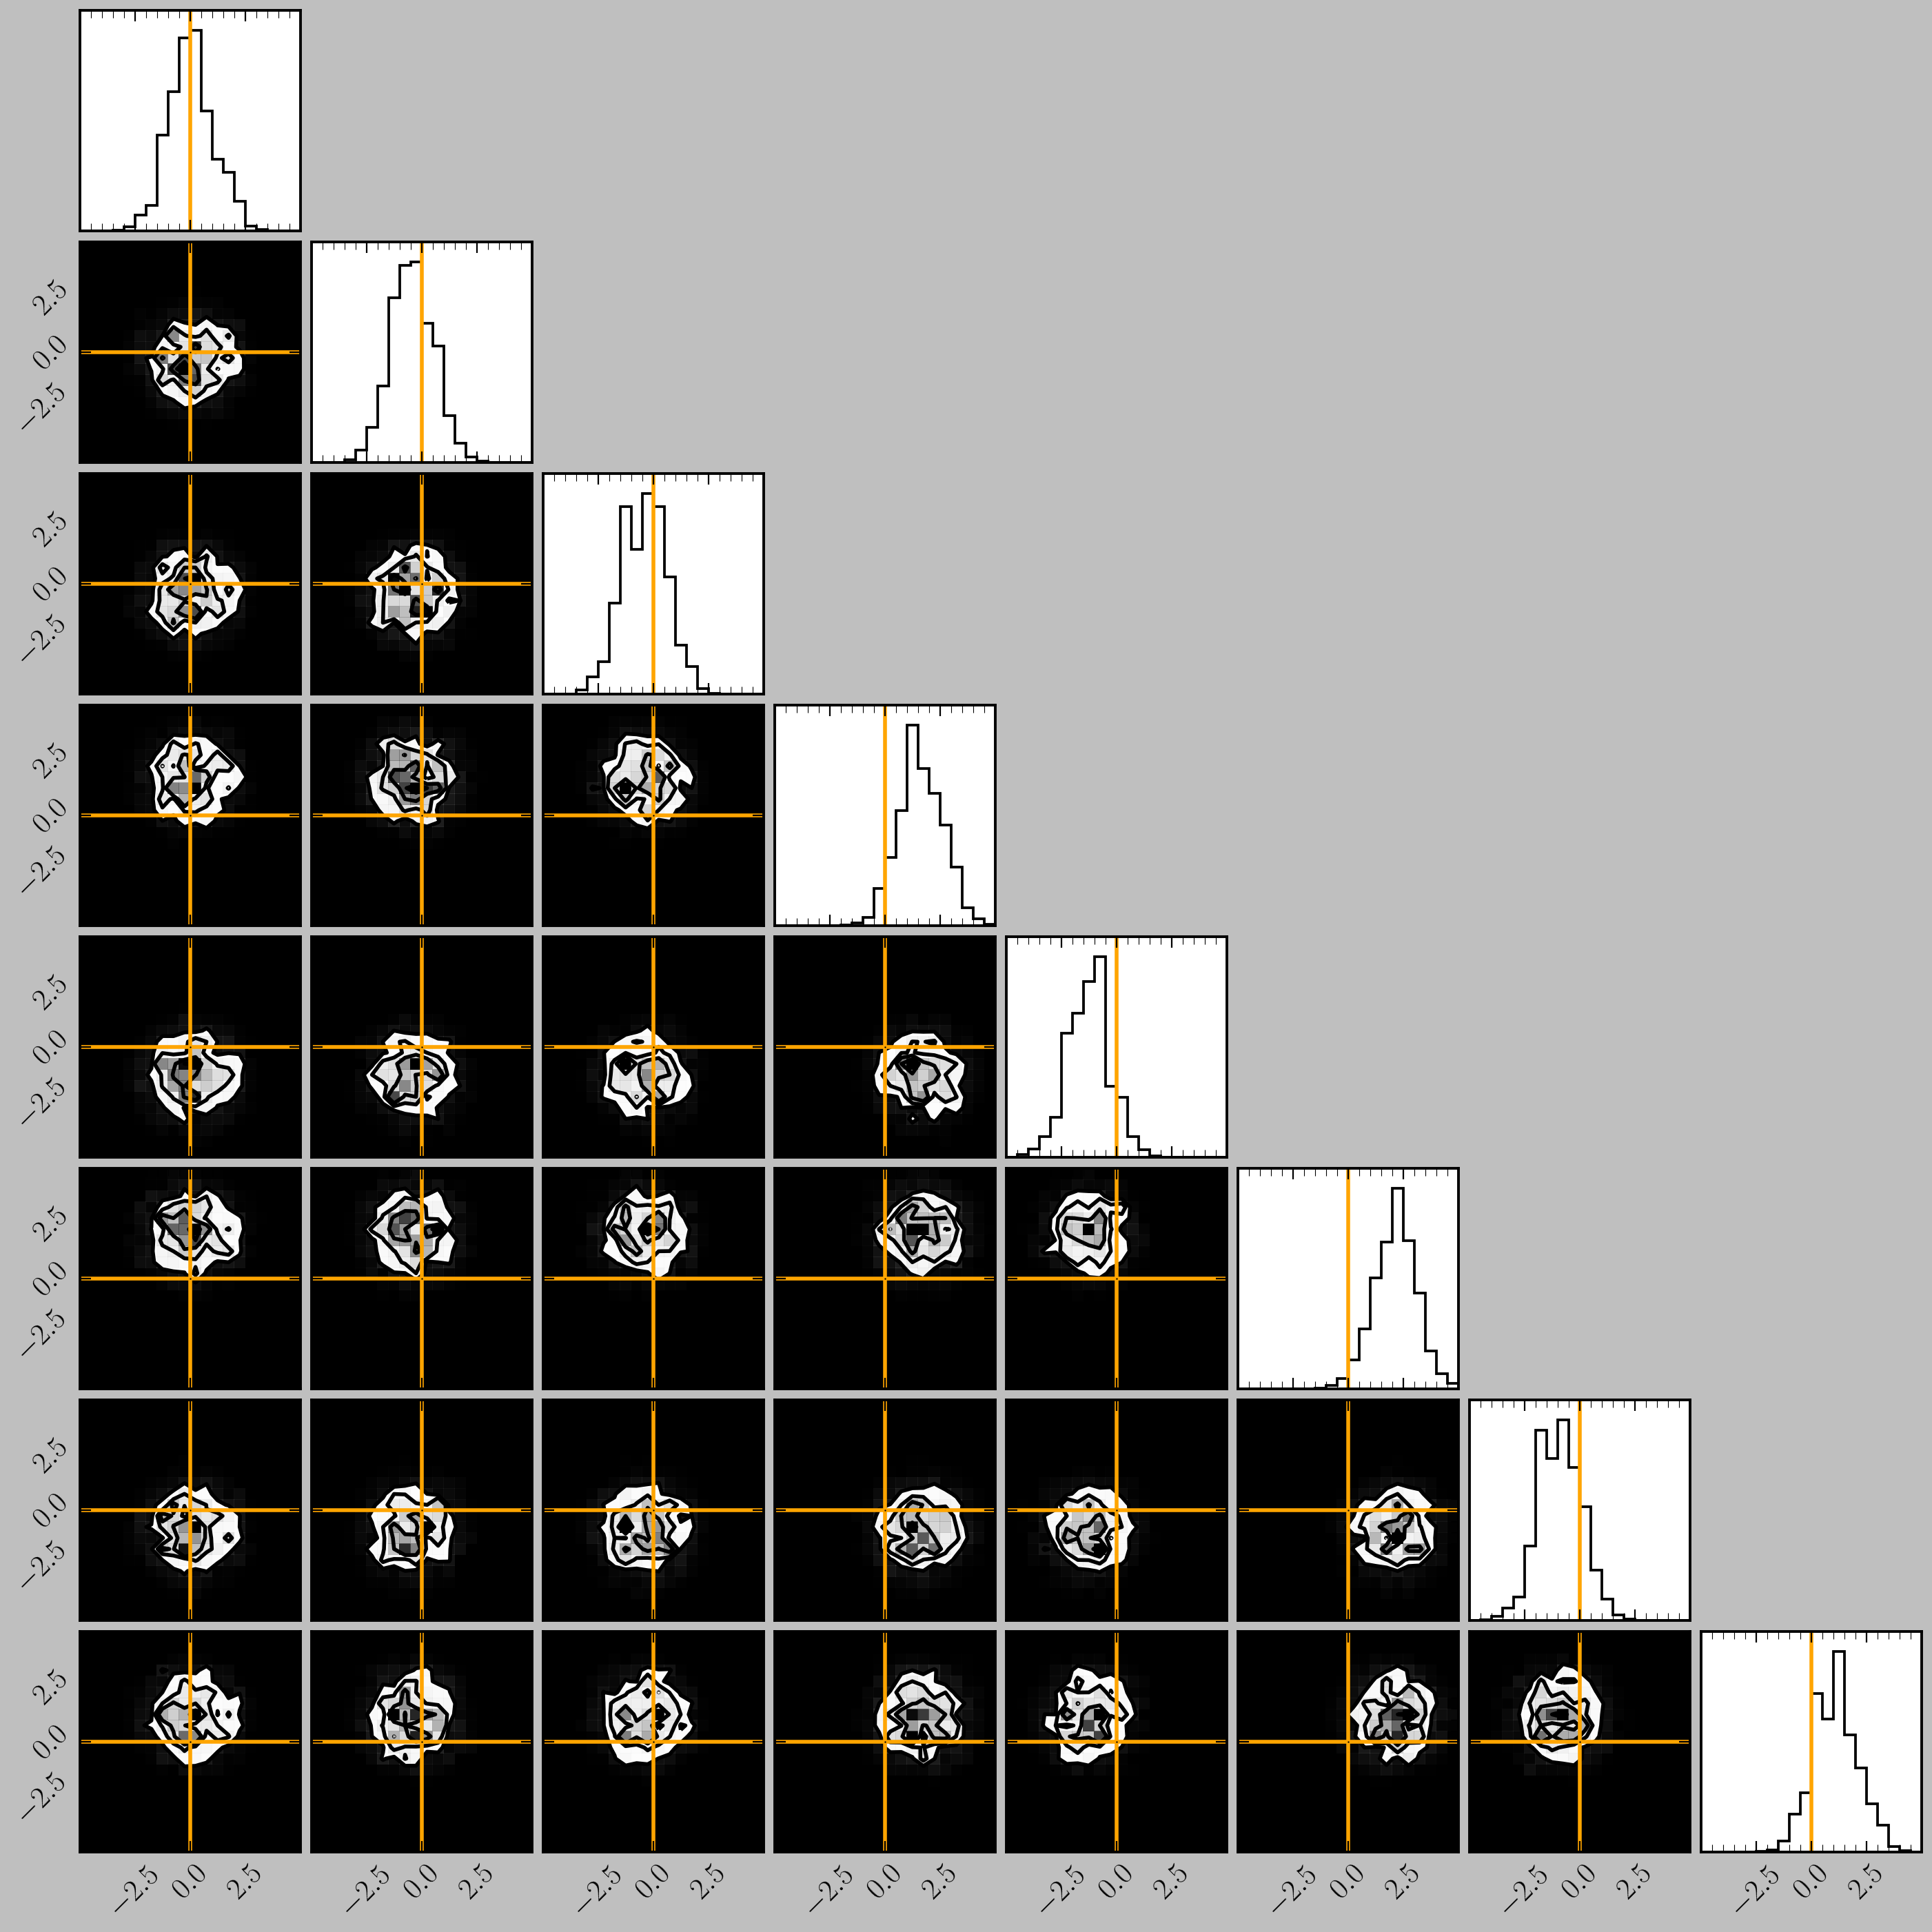

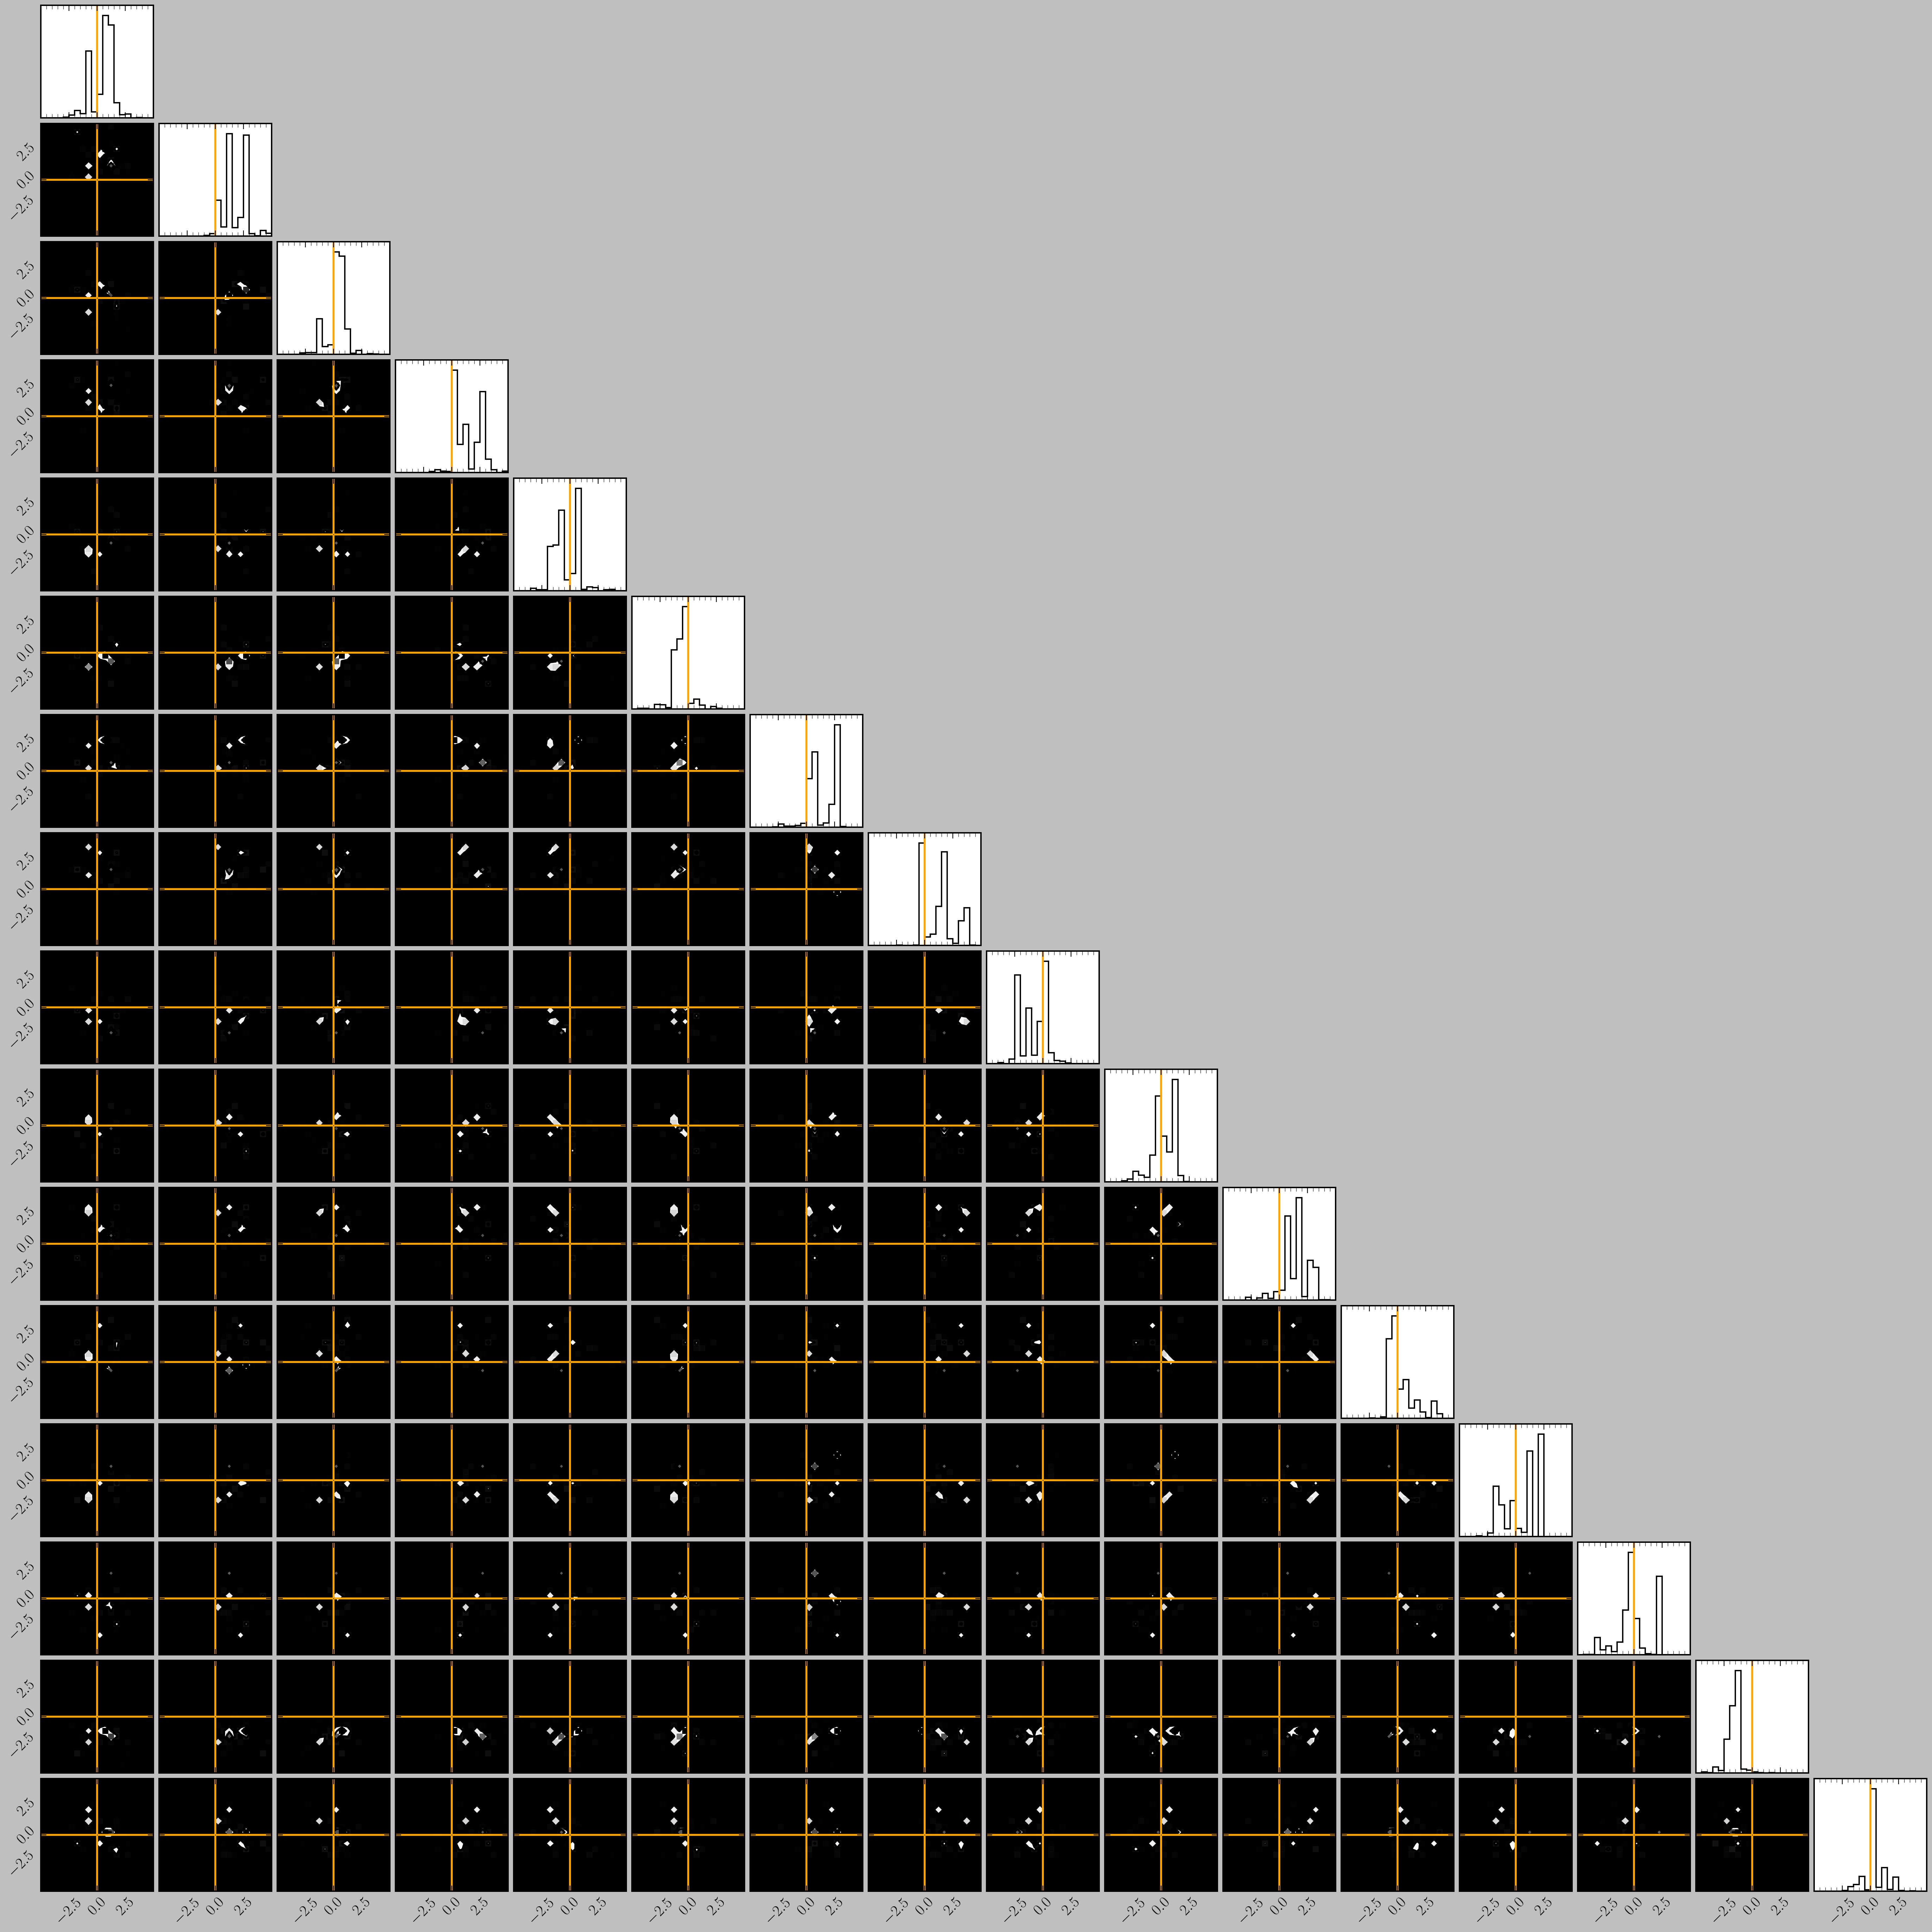

In [6]:
N_samples = 1000000
Ndim = 1
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)

x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.show()

Ndim = 2
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)

x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.show()

Ndim = 4
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)

x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.show()

Ndim = 8
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)

x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.plot(np.linspace(-5, 5, 100), color="red", label="Gaussian")
plt.show()

Ndim = 16
posterior = Posterior(prior=Prior(Ndim=Ndim), likelihood=Likelihood(Ndim=Ndim))
theta_true = jnp.zeros(Ndim)

x_data = posterior.likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
theta_sample = posterior.prior.sample(N_samples)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_sample, x_data)
corner.corner(np.array(theta_sample), weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))), truths=theta_true, truth_color="orange")
plt.plot(np.linspace(-5, 5, 100), color="red", label="Gaussian")
plt.show()